In [131]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")


In [140]:
## Import the Data and Predictions
deaths_true = pd.read_csv("../../data/usafacts/deaths.csv")

## Getting the columns we want
deaths_true = deaths_true[["State", "4/2/20"]].groupby("State")\
    .agg( {'4/2/20':  'sum'}).reset_index().rename(columns={"State": "state", "4/2/20": "deaths"})


# predictions
deaths_pred = pd.read_csv("./yugroup/03_31.csv")
deaths_pred = deaths_pred[deaths_pred["state"] != "US"]

# IHME predictions
deaths_ihme = pd.read_csv("./ihme/2020-03-31.csv")
filtered_cols = ["Other Counties, WA", "US","King and Snohomish Counties (excluding Life Care Center), WA",
                                               "Life Care Center, Kirkland, WA"]
deaths_ihme = \
    deaths_ihme[~deaths_ihme["location"].isin(filtered_cols)]
deaths_ihme["state"] = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT",  "DE", "DC","FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"] 
deaths_ihme = deaths_ihme[["state", "3_day_cumul_mean"]].rename(columns={"3_day_cumul_mean": "3_day_mean"})

In [141]:
### PROCESS THE MODEL WE WANT HERE
deaths_pred = deaths_pred[["state", "predicted_deaths_ensemble_3"]]
# deaths_pred = deaths_pred[["state", "predicted_deaths_simple_ensemble_3"]]\
#     .rename(columns={"predicted_deaths_simple_ensemble_3": "predicted_deaths_ensemble_3"})

In [142]:
# Dataframe of Truth and Lies (Predictions)
df = deaths_true.merge(deaths_pred, how="left", on="state")\
    .merge(deaths_ihme, how="left", on="state")

In [143]:
## Let's Compute some losses

# L1 Loss
df = df.assign(l1_ours=lambda x: np.abs(x.deaths - x.predicted_deaths_ensemble_3))
df = df.assign(l1_theirs = lambda x: np.abs(x.deaths - x["3_day_mean"]))

# L2 Loss
df = df.assign(l2_ours=lambda x: (x.deaths - x.predicted_deaths_ensemble_3)**2)
df = df.assign(l2_theirs = lambda x: (x.deaths - x["3_day_mean"])**2)

# Log L1 Loss
df = df.assign(l1_log_ours=lambda x: np.log(np.abs(x.deaths - x.predicted_deaths_ensemble_3) + 1))
df = df.assign(l1_log_theirs = lambda x: np.log(np.abs(x.deaths - x["3_day_mean"]) + 1))

# Log L2 Loss
df = df.assign(l2_log_ours=lambda x: np.log((x.deaths - x.predicted_deaths_ensemble_3)**2 + 1))
df = df.assign(l2_log_theirs = lambda x: np.log((x.deaths - x["3_day_mean"])**2 + 1))


## Compute the Results
res_cols = ["l1_ours", "l1_theirs", 
           "l2_ours", "l2_theirs",
            "l1_log_ours", "l1_log_theirs",
           "l2_log_ours", "l2_log_theirs"]
res = df[res_cols]

res.agg("sum")

l1_ours            2224.316844
l1_theirs          1293.416000
l2_ours          383279.657078
l2_theirs        369438.852670
l1_log_ours         153.787515
l1_log_theirs       105.302764
l2_log_ours         299.104978
l2_log_theirs       195.894484
dtype: float64

In [144]:
df.head()

,state,deaths,predicted_deaths_ensemble_3,3_day_mean,l1_ours,l1_theirs,l2_ours,l2_theirs,l1_log_ours,l1_log_theirs,l2_log_ours,l2_log_theirs
0,AK,3,3.911360,12.646,0.911360,9.646,0.830577,93.045316,0.647815,2.365184,0.604631,4.543777
1,AL,17,44.422568,77.687,27.422568,60.687,751.997241,3682.911969,3.347183,4.122073,6.624062,8.211731
2,AR,12,24.136461,14.845,12.136461,2.845,147.293680,8.094025,2.575392,1.346774,4.999195,2.207618
3,AZ,32,44.323785,41.760,12.323785,9.760,151.875671,95.257600,2.589551,2.375836,5.029625,4.567028
4,CA,243,352.877446,277.375,109.877446,34.375,12073.053159,1181.640625,4.708426,3.566005,9.398814,7.075505


[Text(0, 0.5, 'IHME Model 3 Day Mean'),
 Text(0.5, 0, '(Log) Number of Deaths per State on 4/3/2020')]

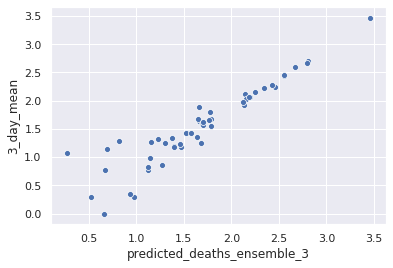

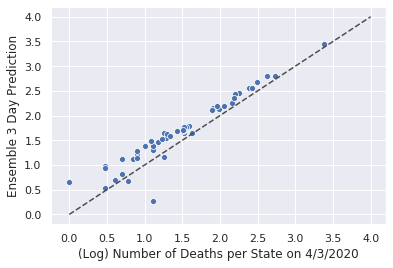

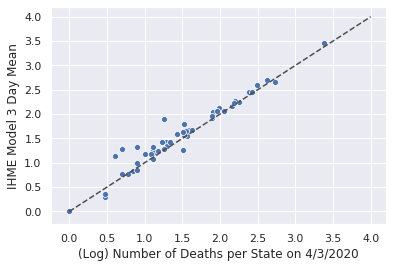

In [145]:
## Scatter Plots
# Log Transform since idk seaborn
plt_df = np.log10(df[["deaths"]] + 1)
plt_df["predicted_deaths_ensemble_3"] = np.log10(df["predicted_deaths_ensemble_3"] + 1)
plt_df["3_day_mean"] = np.log10(df["3_day_mean"] + 1)


# Our Preds -- Their Preds
f, ax = plt.subplots()
sns.scatterplot(x = "predicted_deaths_ensemble_3", y="3_day_mean", data=plt_df)

# Our Preds -- Real Data
f, ax = plt.subplots()
ax.plot([0, 4],[0,4], 
                        ls="--", c=".3")
sns.scatterplot(x = "deaths", y="predicted_deaths_ensemble_3", data=plt_df)
ax.set(ylabel="Ensemble 3 Day Prediction",
      xlabel="(Log) Number of Deaths per State on 4/3/2020")

# Their Preds Real Data
f, ax = plt.subplots()
ax.plot([0,4],[0, 4], 
                        ls="--", c=".3")
sns.scatterplot(x = "deaths", y="3_day_mean", data=plt_df)
ax.set(ylabel="IHME Model 3 Day Mean",
      xlabel="(Log) Number of Deaths per State on 4/3/2020")